# 初步探索poisson table
- log2_FC: log2(treat_count.norm/ctrl_count.norm), 如果ctrl_count.norm不存在，就用 chr 突变背景
- log2_FC_mut: log2(treat_mut_count.norm/ctrl_mut_count.norm), 如果ctrl_mut_count.norm不存在，就用 chr 突变背景
- region_block_state: B-Blocked, S-SNV, N-Non-SNV

In [1]:
import os
import sys

import numpy as np
import pandas as pd

In [2]:
file = '../poisson_res/poisson_res_all.tsv.gz'

In [3]:
df = pd.read_csv(file, header=0, index_col=None, sep='\t')
df.head()

,<sample>,chr_name,region_start,region_end,mpmat_index,region_site_num,region_block_site_num,region_mut_site_num,region_site_index,region_block_state,...,ctrl_count.norm,treat_count.norm,ctrl_mut_count.norm,treat_mut_count.norm,count_info,log2_FC,log2_FC_mut,test_state,p_value,FDR
0,DetectSeq_ATP8-DddA11_REP-1,chr1,31029,31037,chr1_31029_31037,4,1,3,"chr1_31029_GA,chr1_31030_G.,chr1_31031_GA,chr1...",B-N-N-N,...,0.005063,0.035765,0.0,0.005961,"0,1,2,3,4 2,0,0,0,0 5,0,1,0,0",2.820479,-0.442445,TestOK,0.582932,0.714251
1,DetectSeq_ATP8-DddA11_REP-1,chr1,56485,56490,chr1_56485_56490,4,1,3,"chr1_56485_CT,chr1_56487_CT,chr1_56488_C.,chr1...",B-N-N-N,...,0.025315,0.041726,0.0,0.005961,"0,1,2,3,4 10,0,0,0,0 6,0,1,0,0",0.720943,-0.442445,TestOK,0.582932,0.714251
2,DetectSeq_ATP8-DddA11_REP-1,chr1,56638,56647,chr1_56638_56647,3,0,3,"chr1_56638_CT,chr1_56641_C.,chr1_56647_CT",N-N-N,...,0.040504,0.077491,0.0,0.000000,"0,1,2,3 16,0,0,0 3,10,0,0",0.935956,NaN,TestOK,0.841752,0.841765
3,DetectSeq_ATP8-DddA11_REP-1,chr1,63226,63239,chr1_63226_63239,5,1,4,"chr1_63226_CT,chr1_63227_C.,chr1_63230_CT,chr1...",N-N-N-N-B,...,0.053162,0.065569,0.0,0.005961,"0,1,2,3,4,5 21,0,0,0,0,0 10,0,0,1,0,0",0.302631,-0.442445,TestOK,0.582932,0.714251
4,DetectSeq_ATP8-DddA11_REP-1,chr1,70291,70300,chr1_70291_70300,3,0,3,"chr1_70291_CT,chr1_70292_CA,chr1_70300_CT",N-N-N,...,0.040504,0.113256,0.0,0.011922,"0,1,2,3 15,1,0,0 11,6,2,0",1.483444,0.557555,TestOK,0.377620,0.580319


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1562657 entries, 0 to 1562656
Data columns (total 28 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   <sample>                       1562657 non-null  object 
 1   chr_name                       1562657 non-null  object 
 2   region_start                   1562657 non-null  int64  
 3   region_end                     1562657 non-null  int64  
 4   mpmat_index                    1562657 non-null  object 
 5   region_site_num                1562657 non-null  int64  
 6   region_block_site_num          1562657 non-null  int64  
 7   region_mut_site_num            1562657 non-null  int64  
 8   region_site_index              1562657 non-null  object 
 9   region_block_state             1562657 non-null  object 
 10  region_highest_site_index      1546820 non-null  object 
 11  region_highest_site_mut_num    1562657 non-null  int64  
 12  region_highest

In [5]:
df.isna().sum()

<sample>                              0
chr_name                              0
region_start                          0
region_end                            0
mpmat_index                           0
region_site_num                       0
region_block_site_num                 0
region_mut_site_num                   0
region_site_index                     0
region_block_state                    0
region_highest_site_index         15837
region_highest_site_mut_num           0
region_highest_site_cover_num         0
region_highest_site_mut_ratio         0
ctrl_count                            0
treat_count                           0
ctrl_mut_count                        0
treat_mut_count                       0
ctrl_count.norm                       0
treat_count.norm                      0
ctrl_mut_count.norm                   0
treat_mut_count.norm                  0
count_info                            0
log2_FC                               0
log2_FC_mut                      229694


In [21]:
# # 查看一下两列 NA 是什么
# test_df = df.query('region_highest_site_index.isna()')
# test2_df = df.query('log2_FC_mut.isna()')

In [61]:
df = df.assign(
    bed_name = df.mpmat_index + '_highest_' + df.region_highest_site_index,
    strand = '.'
)
df

,<sample>,chr_name,region_start,region_end,mpmat_index,region_site_num,region_block_site_num,region_mut_site_num,region_site_index,region_block_state,...,ctrl_mut_count.norm,treat_mut_count.norm,count_info,log2_FC,log2_FC_mut,test_state,p_value,FDR,bed_name,strand
0,DetectSeq_ATP8-DddA11_REP-1,chr1,31029,31037,chr1_31029_31037,4,1,3,"chr1_31029_GA,chr1_31030_G.,chr1_31031_GA,chr1...",B-N-N-N,...,0.0,0.005961,"0,1,2,3,4 2,0,0,0,0 5,0,1,0,0",2.820479,-0.442445,TestOK,0.582932,0.714251,chr1_31029_31037_highest_chr1_31031_GA,.
1,DetectSeq_ATP8-DddA11_REP-1,chr1,56485,56490,chr1_56485_56490,4,1,3,"chr1_56485_CT,chr1_56487_CT,chr1_56488_C.,chr1...",B-N-N-N,...,0.0,0.005961,"0,1,2,3,4 10,0,0,0,0 6,0,1,0,0",0.720943,-0.442445,TestOK,0.582932,0.714251,chr1_56485_56490_highest_chr1_56487_CT,.
2,DetectSeq_ATP8-DddA11_REP-1,chr1,56638,56647,chr1_56638_56647,3,0,3,"chr1_56638_CT,chr1_56641_C.,chr1_56647_CT",N-N-N,...,0.0,0.000000,"0,1,2,3 16,0,0,0 3,10,0,0",0.935956,NaN,TestOK,0.841752,0.841765,chr1_56638_56647_highest_chr1_56638_CT,.
3,DetectSeq_ATP8-DddA11_REP-1,chr1,63226,63239,chr1_63226_63239,5,1,4,"chr1_63226_CT,chr1_63227_C.,chr1_63230_CT,chr1...",N-N-N-N-B,...,0.0,0.005961,"0,1,2,3,4,5 21,0,0,0,0,0 10,0,0,1,0,0",0.302631,-0.442445,TestOK,0.582932,0.714251,chr1_63226_63239_highest_chr1_63226_CT,.
4,DetectSeq_ATP8-DddA11_REP-1,chr1,70291,70300,chr1_70291_70300,3,0,3,"chr1_70291_CT,chr1_70292_CA,chr1_70300_CT",N-N-N,...,0.0,0.011922,"0,1,2,3 15,1,0,0 11,6,2,0",1.483444,0.557555,TestOK,0.377620,0.580319,chr1_70291_70300_highest_chr1_70300_CT,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562652,DetectSeq_SIRT6-DddA11_REP-1,chrX,155948218,155948220,chrX_155948218_155948220,2,0,2,"chrX_155948218_CT,chrX_155948220_CT",N-N,...,0.0,0.000000,"0,1,2 0,0,0 5,0,4",-0.208028,NaN,TestOK,0.806282,0.846502,chrX_155948218_155948220_highest_chrX_15594821...,.
1562653,DetectSeq_SIRT6-DddA11_REP-1,chrX,155948229,155948244,chrX_155948229_155948244,4,0,4,"chrX_155948229_GA,chrX_155948233_GA,chrX_15594...",N-N-N-N,...,0.0,0.000000,"0,1,2,3,4 0,0,0,0,0 5,0,0,4,0",-0.208028,NaN,TestOK,0.806282,0.846502,chrX_155948229_155948244_highest_chrX_15594822...,.
1562654,DetectSeq_SIRT6-DddA11_REP-1,chrX,155974406,155974427,chrX_155974406_155974427,7,0,7,"chrX_155974406_CT,chrX_155974413_CT,chrX_15597...",N-N-N-N-N-N-N,...,0.0,0.016684,"0,1,2,3,4,5,6,7 0,0,0,0,0,0,0,0 17,4,1,2,0,0,0,0",1.207009,1.310806,TestOK,0.192759,0.318252,chrX_155974406_155974427_highest_chrX_15597442...,.
1562655,DetectSeq_SIRT6-DddA11_REP-1,chrX,156022047,156022062,chrX_156022047_156022062,4,0,4,"chrX_156022047_GA,chrX_156022048_GA,chrX_15602...",N-N-N-N,...,0.0,0.016684,"0,1,2,3,4 0,0,0,0,0 4,6,3,0,0",0.322486,1.310806,TestOK,0.192759,0.318252,chrX_156022047_156022062_highest_chrX_15602206...,.


# find significant region

## strict selection 

In [62]:
df_sign_strict = (df
    .query('FDR <= 0.0001')  # 10911
    .query('log2_FC_mut >= 2')  # 10911
    .query('ctrl_mut_count <= 1')  # 9551
    .query('`treat_mut_count.norm` * 100 >= 10')  # 9551
    .query('treat_mut_count >= 20')  # 9551
    .query('treat_mut_count / treat_count >= 0.15')  # 6080
    .query('region_block_site_num <= 1')  # 5720
    .query('region_highest_site_mut_ratio >= 0.35')  # 2929
)

print(df_sign_strict.shape[0])
df_sign_strict.groupby('<sample>').describe()

2929


region_start                              \
                                    count          mean           std   
<sample>                                                                
DetectSeq_ATP8-DddA11_REP-1         160.0  7.232652e+07  5.417281e+07   
DetectSeq_ATP8-DddA6_REP-1          369.0  7.323834e+07  5.282204e+07   
DetectSeq_ATP8-DddAwt_REP-1          88.0  5.356781e+07  4.259521e+07   
DetectSeq_JAK2-DddA11_REP-1         603.0  7.351632e+07  5.350346e+07   
DetectSeq_SIRT6-DddA11_REP-1       1709.0  7.521779e+07  5.457469e+07   

                                                                               \
                                   min          25%         50%           75%   
<sample>                                                                        
DetectSeq_ATP8-DddA11_REP-1   630957.0  27081692.75  60138169.5  1.142059e+08   
DetectSeq_ATP8-DddA6_REP-1    630440.0  30522027.00  60296487.0  1.121915e+08   
DetectSeq_ATP8-DddAwt_REP-1   631391.0  22923202.25  49321013.5  6.067799e+07   
DetectSeq_JAK2-DddA11_REP-1   686172.0  32317164.50  60225127.0  1.082117e+08   
DetectSeq_SIRT6-DddA11_REP-1  242415.0  31532755.00  60917089.0  1.103109e+08   

                                          region_end                ...  \
                                      max      count          mean  ...   
<sample>                                                            ...   
DetectSeq_ATP8-DddA11_REP-1   242043276.0      160.0  7.232658e+07  ...   
DetectSeq_ATP8-DddA6_REP-1    230513936.0      369.0  7.323841e+07  ...   
DetectSeq_ATP8-DddAwt_REP-1   201232409.0       88.0  5.356787e+07  ...   
DetectSeq_JAK2-DddA11_REP-1   246696632.0      603.0  7.351637e+07  ...   
DetectSeq_SIRT6-DddA11_REP-1  248905893.0     1709.0  7.521785e+07  ...   

                                   p_value                   FDR            \
                                       75%           max   count      mean   
<sample>                                                                     
DetectSeq_ATP8-DddA11_REP-1   5.548434e-09  4.032488e-07   160.0  0.000006   
DetectSeq_ATP8-DddA6_REP-1    2.354367e-08  5.105593e-07   369.0  0.000010   
DetectSeq_ATP8-DddAwt_REP-1   8.644648e-09  1.531386e-07    88.0  0.000009   
DetectSeq_JAK2-DddA11_REP-1   1.114112e-08  6.482170e-07   603.0  0.000009   
DetectSeq_SIRT6-DddA11_REP-1  1.577425e-08  1.137115e-06  1709.0  0.000007   

                                                                     \
                                   std            min           25%   
<sample>                                                              
DetectSeq_ATP8-DddA11_REP-1   0.000015   0.000000e+00  1.145206e-20   
DetectSeq_ATP8-DddA6_REP-1    0.000023   0.000000e+00  1.200588e-11   
DetectSeq_ATP8-DddAwt_REP-1   0.000018   0.000000e+00  1.705089e-11   
DetectSeq_JAK2-DddA11_REP-1   0.000022   1.172614e-99  4.837212e-18   
DetectSeq_SIRT6-DddA11_REP-1  0.000016  6.405502e-146  3.677355e-16   

                                                                
                                       50%       75%       max  
<sample>                                                        
DetectSeq_ATP8-DddA11_REP-1   3.628154e-09  0.000002  0.000086  
DetectSeq_ATP8-DddA6_REP-1    1.471017e-07  0.000006  0.000098  
DetectSeq_ATP8-DddAwt_REP-1   9.436538e-08  0.000005  0.000067  
DetectSeq_JAK2-DddA11_REP-1   5.682422e-10  0.000002  0.000099  
DetectSeq_SIRT6-DddA11_REP-1  2.551968e-09  0.000002  0.000091  

[5 rows x 160 columns]

In [63]:
df_sign_strict.isna().sum().sum()

0

## lenient selection

In [64]:
df_sign_lenient = (df
    .query('FDR <= 0.01')  # 25118
    .query('log2_FC_mut >= 2')  # 25118
    .query('ctrl_mut_count <= 1')  # 22009
    .query('`treat_mut_count.norm` * 100 >= 5')  # 22009
    .query('treat_mut_count >= 10')  # 22009
    .query('treat_mut_count / treat_count >= 0.15')  # 14476
    .query('region_block_site_num <= 1')  # 13522
    .query('region_highest_site_mut_ratio >= 0.30')  # 7001
)

print(df_sign_lenient.shape[0])
df_sign_lenient.groupby('<sample>').describe()

7001


region_start                              \
                                    count          mean           std   
<sample>                                                                
DetectSeq_ATP8-DddA11_REP-1         390.0  7.140489e+07  5.268447e+07   
DetectSeq_ATP8-DddA6_REP-1         1062.0  7.820919e+07  5.445423e+07   
DetectSeq_ATP8-DddAwt_REP-1         198.0  5.664861e+07  4.505448e+07   
DetectSeq_JAK2-DddA11_REP-1        1122.0  7.074730e+07  5.271937e+07   
DetectSeq_SIRT6-DddA11_REP-1       4229.0  7.598211e+07  5.510585e+07   

                                                                              \
                                   min          25%         50%          75%   
<sample>                                                                       
DetectSeq_ATP8-DddA11_REP-1   630957.0  26449309.50  59933966.5  109372023.5   
DetectSeq_ATP8-DddA6_REP-1     58741.0  34931723.00  65550265.5  113457006.0   
DetectSeq_ATP8-DddAwt_REP-1   631391.0  22815892.00  50126483.5   62436712.5   
DetectSeq_JAK2-DddA11_REP-1   497136.0  28627039.75  58011844.5  103544116.5   
DetectSeq_SIRT6-DddA11_REP-1   49953.0  31975522.00  62469941.0  111973236.0   

                                          region_end                ...  \
                                      max      count          mean  ...   
<sample>                                                            ...   
DetectSeq_ATP8-DddA11_REP-1   242043276.0      390.0  7.140495e+07  ...   
DetectSeq_ATP8-DddA6_REP-1    246387176.0     1062.0  7.820925e+07  ...   
DetectSeq_ATP8-DddAwt_REP-1   228622163.0      198.0  5.664866e+07  ...   
DetectSeq_JAK2-DddA11_REP-1   246696632.0     1122.0  7.074735e+07  ...   
DetectSeq_SIRT6-DddA11_REP-1  248905893.0     4229.0  7.598216e+07  ...   

                               p_value               FDR                      \
                                   75%       max   count      mean       std   
<sample>                                                                       
DetectSeq_ATP8-DddA11_REP-1   0.000013  0.000071   390.0  0.001397  0.002228   
DetectSeq_ATP8-DddA6_REP-1    0.000022  0.000111  1062.0  0.001802  0.002871   
DetectSeq_ATP8-DddAwt_REP-1   0.000007  0.000040   198.0  0.001615  0.002530   
DetectSeq_JAK2-DddA11_REP-1   0.000010  0.000131  1122.0  0.001164  0.002306   
DetectSeq_SIRT6-DddA11_REP-1  0.000033  0.000308  4229.0  0.001592  0.002827   

                                                                               \
                                        min           25%       50%       75%   
<sample>                                                                        
DetectSeq_ATP8-DddA11_REP-1    0.000000e+00  7.914552e-09  0.000078  0.001880   
DetectSeq_ATP8-DddA6_REP-1     0.000000e+00  3.674352e-07  0.000188  0.002568   
DetectSeq_ATP8-DddAwt_REP-1    0.000000e+00  1.808493e-07  0.000127  0.002013   
DetectSeq_JAK2-DddA11_REP-1    1.172614e-99  1.105413e-11  0.000005  0.001209   
DetectSeq_SIRT6-DddA11_REP-1  6.405502e-146  2.534612e-09  0.000032  0.001646   

                                        
                                   max  
<sample>                                
DetectSeq_ATP8-DddA11_REP-1   0.008006  
DetectSeq_ATP8-DddA6_REP-1    0.009767  
DetectSeq_ATP8-DddAwt_REP-1   0.009130  
DetectSeq_JAK2-DddA11_REP-1   0.009687  
DetectSeq_SIRT6-DddA11_REP-1  0.009766  

[5 rows x 160 columns]

In [65]:
df_sign_lenient.isna().sum().sum()

0

In [66]:
df_igv = df_sign_lenient[['chr_name', 'region_start', 'region_end', 'bed_name', 'log2_FC_mut']]

# IGV 截图脚本

In [67]:
import pybedtools as bt

In [95]:
bed = bt.BedTool.from_dataframe(df_igv)
bed = bed.sort()
bed = bed.merge(d=20)
df_bed = bed.to_dataframe()
df_bed = df_bed.assign(region_length=df_bed.end - df_bed.start)
df_bed = df_bed.reset_index()
df_bed

,index,chrom,start,end,region_length
0,0,chr1,268547,268579,32
1,1,chr1,630440,630496,56
2,2,chr1,630957,631045,88
3,3,chr1,631215,631310,95
4,4,chr1,631391,631444,53
...,...,...,...,...,...
5442,5442,chrX,154924102,154924198,96
5443,5443,chrX,155049207,155049224,17
5444,5444,chrX,155439898,155439954,56
5445,5445,chrX,155570076,155570156,80


In [100]:
df_bed.region_length.quantile([0.05, 0.95])

0.05    21.0
0.95    97.0
Name: region_length, dtype: float64

<AxesSubplot: >

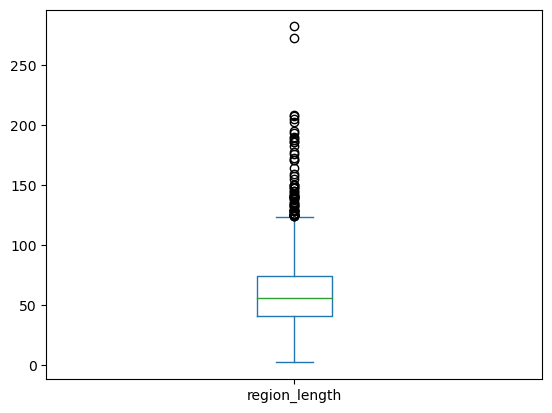

In [98]:
df_bed.plot(x='index', y='region_length', kind='box')

In [97]:
df_bed.plot?

Signature:      df_bed.plot(*args, **kwargs)
Type:           PlotAccessor
String form:    <pandas.plotting._core.PlotAccessor object at 0x1afb09db0>
File:           /usr/local/Caskroom/miniconda/base/lib/python3.10/site-packages/pandas/plotting/_core.py
Docstring:     
Make plots of Series or DataFrame.

Uses the backend specified by the
option ``plotting.backend``. By default, matplotlib is used.

Parameters
----------
data : Series or DataFrame
    The object for which the method is called.
x : label or position, default None
    Only used if data is a DataFrame.
y : label, position or list of label, positions, default None
    Allows plotting of one column versus another. Only used if data is a
    DataFrame.
kind : str
    The kind of plot to produce:

    - 'line' : line plot (default)
    - 'bar' : vertical bar plot
    - 'barh' : horizontal bar plot
    - 'hist' : histogram
    - 'box' : boxplot
    - 'kde' : Kernel Density Estimation plot
    - 'density' : same as 'kde'
    - '

In [ ]:
bed.to_dataframe()

In [16]:
df_sign_lenient

# bedtools merge -i input.bed

# https://daler.github.io/pybedtools/autodocs/pybedtools.bedtool.BedTool.merge.html#pybedtools.bedtool.BedTool.merge

,<sample>,chr_name,region_start,region_end,mpmat_index,region_site_num,region_block_site_num,region_mut_site_num,region_site_index,region_block_state,...,ctrl_count.norm,treat_count.norm,ctrl_mut_count.norm,treat_mut_count.norm,count_info,log2_FC,log2_FC_mut,test_state,p_value,FDR
59,DetectSeq_ATP8-DddA11_REP-1,chr1,630957,631045,chr1_630957_631045,20,0,20,"chr1_630957_CT,chr1_630960_CT,chr1_630968_CT,c...",N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N,...,0.108855,48.837213,0.000000,13.578808,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18...",8.809428,10.711107,TestOK,0.000000e+00,0.000000e+00
65,DetectSeq_ATP8-DddA11_REP-1,chr1,631232,631310,chr1_631232_631310,20,0,20,"chr1_631232_CT,chr1_631235_CT,chr1_631238_CT,c...",N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N,...,0.101261,27.431814,0.000000,5.996611,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18...",8.081634,9.531969,TestOK,0.000000e+00,0.000000e+00
75,DetectSeq_ATP8-DddA11_REP-1,chr1,631598,631648,chr1_631598_631648,20,0,20,"chr1_631598_CT,chr1_631603_CT,chr1_631604_CT,c...",N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N,...,0.091135,8.202124,0.000000,2.664498,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18...",6.491856,8.361686,TestOK,2.320369e-173,6.468592e-170
81,DetectSeq_ATP8-DddA11_REP-1,chr1,631823,631921,chr1_631823_631921,20,0,20,"chr1_631823_CT,chr1_631826_CT,chr1_631835_CT,c...",N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N,...,0.101261,25.160732,0.002532,4.315653,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18...",7.956958,10.735363,TestOK,3.683301e-287,1.382244e-283
83,DetectSeq_ATP8-DddA11_REP-1,chr1,631932,632007,chr1_631932_632007,20,0,20,"chr1_631932_CT,chr1_631940_CT,chr1_631942_CT,c...",N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N,...,0.098729,37.094346,0.000000,6.449636,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18...",8.553509,9.637039,TestOK,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562475,DetectSeq_SIRT6-DddA11_REP-1,chrX,154457793,154457822,chrX_154457793_154457822,12,0,12,"chrX_154457793_CT,chrX_154457797_CT,chrX_15445...",N-N-N-N-N-N-N-N-N-N-N-N,...,0.017721,0.300308,0.000000,0.122348,"0,1,2,3,4,5,6,7,8,9,10,11,12 7,0,0,0,0,0,0,0,0...",4.082944,4.185275,TestOK,3.538418e-07,3.182519e-05
1562532,DetectSeq_SIRT6-DddA11_REP-1,chrX,154924102,154924198,chrX_154924102_154924198,20,0,20,"chrX_154924102_CT,chrX_154924110_CT,chrX_15492...",N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N-N,...,0.131639,0.194644,0.000000,0.111225,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18...",0.564255,4.047772,TestOK,1.633547e-06,1.243886e-04
1562550,DetectSeq_SIRT6-DddA11_REP-1,chrX,155049207,155049224,chrX_155049207_155049224,8,0,8,"chrX_155049207_GA,chrX_155049210_GA,chrX_15504...",N-N-N-N-N-N-N-N,...,0.070882,0.856434,0.002532,0.533881,"0,1,2,3,4,5,6,7,8 27,0,0,1,0,0,0,0,0 25,33,54,...",3.594843,7.720374,TestOK,2.760115e-34,4.283753e-31
1562610,DetectSeq_SIRT6-DddA11_REP-1,chrX,155439898,155439954,chrX_155439898_155439954,15,1,14,"chrX_155439898_GA,chrX_155439903_GA,chrX_15543...",N-N-N-N-N-N-N-N-B-N-N-N-N-N-N,...,0.088603,0.344798,0.000000,0.150154,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15 32,3,0,0...",1.960325,4.480731,TestOK,7.180691e-09,9.388518e-07


In [ ]:
# 整理df格式为bed文件格式


print(df)

#        0          1          2
# 0   chr5   69093805   69093830
# 1   chr8   37153384   37153424
# 2  chr15   57559994   57560017
# 3  chr15   68651256   68651277
# 4  chr10  119445511  119445546
# 5   chr8   20184990   20185028
# 6  chr19   45187694   45187712
# 7  chr15   81265992   81266016
# 8   chr2  201232409  201232430
# 9   chr9   98034893   98034930


# 填写相关信息

path_out = '/Users/zhaohuanan/zhaohn_HD/3.projects/2021_DdCBE_topic/20210315_DdCBE_igv/igv-snapshot'
date = 20210315
format_ = "png"
height = 1500



# 格式化脚本
text = "maxPanelHeight {height}\nsnapshotDirectory {path}\n".format(height=height,path=path_out)
df = df.iloc[:,0:4]
for chr_, tss, tes, region_name in df.values.tolist():
    path_out_png = '{date}_{chr}_{tss}_{tes}_{name}.snapshot.{format}'.format(date=date,chr=chr_.strip(),tss=tss,tes=tes,format=format_, name=region_name.strip())
    text +="goto {chr}:{tss}-{tes}\nsnapshot {path_out_png}\n".format(chr=chr_.strip(),tss=int(tss)-0,tes=int(tes)+0,path_out_png=path_out_png)
print(text)

with open('./{date}_snapshot.igv_shot_script'.format(date=date), 'w') as f:
    f.write(text)

In [89]:
# DetectSeq_JAK2
# DetectSeq_SIRT6
# IND share?